In [1]:
# Tutti gli import necessari per il notebook
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # Permetti import da root progetto

import torch
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from PIL import Image
import torch.nn as nn
import torchvision.transforms as transforms
import faiss

from functions.utils import diagnose_gpu_cuda , check_cuda_availability , get_device

In [2]:
# Importa le librerie fondamentali
np.random.seed(42)
torch.manual_seed(42)

# Imposta tema scuro per matplotlib
plt.style.use('dark_background')

In [3]:
diagnose_gpu_cuda()

# Verifica se il backend MPS è disponibile (per Apple Silicon)
if hasattr(torch.backends, 'mps'):
    print(f"\nMPS disponibile (Apple Silicon): {torch.backends.mps.is_available()}")
    if torch.backends.mps.is_available():
        print("Utilizzeremo MPS per l'accelerazione su Apple Silicon")
    

=== DIAGNOSI GPU/CUDA ===
Versione Python: 3.10.15 | packaged by conda-forge | (main, Oct 16 2024, 01:24:20) [Clang 17.0.6 ]
Versione PyTorch: 2.2.2

torch.cuda.is_available(): False
CUDA non disponibile

CUDA version compilata in PyTorch: None
PyTorch compilato con CUDA: False

nvidia-smi non trovato o errore: /bin/sh: nvidia-smi: command not found


CUDA_PATH: Non trovato
CUDA_HOME: Non trovato

=== FINE DIAGNOSI ===

MPS disponibile (Apple Silicon): True
Utilizzeremo MPS per l'accelerazione su Apple Silicon


In [4]:
# Funzione per reinstallare PyTorch con supporto CUDA (se necessario)


# reinstall_pytorch_cuda()

In [5]:
check_cuda_availability()

🔍 VERIFICA FINALE DOPO REINSTALLAZIONE:
PyTorch version: 2.2.2
CUDA available: False
❌ CUDA ancora non disponibile. Assicurati di aver riavviato il kernel!


In [6]:


# Utilizza la funzione per determinare il device
device = get_device()



Using device: mps (Apple Silicon MPS)


In [7]:
def rotate_image_90(image):
    """
    Ruota un'immagine di 90 gradi in senso orario.

    Args:
        image (numpy.ndarray o torch.Tensor): L'immagine da ruotare.

    Returns:
        numpy.ndarray o torch.Tensor: L'immagine ruotata.
    """
    if isinstance(image, np.ndarray):
        return np.rot90(image, k=-1)  # Ruota di 90 gradi in senso orario
    elif isinstance(image, torch.Tensor):
        return torch.rot90(image, k=-1, dims=(1, 2))  # Ruota di 90 gradi in senso orario
    else:
        raise TypeError("Il formato dell'immagine deve essere numpy.ndarray o torch.Tensor")

In [8]:
# Definisci MVTecDataset all'inizio del modulo principale
class MVTecDataset(torch.utils.data.Dataset):
    def __init__(self, category, train=True, transform=None):
        self.transform = transform
        self.train = train
        path = os.path.join("../.dataset/mvtecad", category, "train" if train else "test")
        self.good_path = os.path.join(path, "good")
        self.image_paths = []
        self.labels = []
        self.subfolders = []

        if train:
            # Solo immagini good per il training
            self.image_paths = [os.path.join(self.good_path, f) for f in os.listdir(self.good_path) 
                                if f.endswith(('.png', '.jpg', '.jpeg'))]
        else:
            # Per il test: crea sottocartelle per ogni tipo (comprese good)
            for defect_type in os.listdir(path):
                defect_path = os.path.join(path, defect_type)
                if os.path.isdir(defect_path):
                    files = [f for f in os.listdir(defect_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
                    for f in files:
                        self.image_paths.append(os.path.join(defect_path, f))
                        self.labels.append(defect_type)
                        self.subfolders.append(defect_type)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.train:
            return img
        else:
            # Restituisci anche la sottocartella (defect_type) e il nome file
            file_name = os.path.basename(self.image_paths[idx])
            defect_type = self.subfolders[idx]
            return img, defect_type, file_name

# Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Modello convoluzionale
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 25, kernel_size=3, padding=1, padding_mode='replicate')  # Mantieni dimensioni
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(25, 50, kernel_size=3, padding=1, padding_mode='replicate') 
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(50, 75, kernel_size=3, padding=1 , padding_mode='replicate')
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(75, 100, kernel_size=3, padding=1, padding_mode='replicate')
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.relu1(self.conv1(x))  # 25x256x256
        x = self.relu2(self.conv2(x))  # 50x256x256
        x = self.relu3(self.conv3(x))  # 75x256x256
        x = self.relu4(self.conv4(x))  # 100x256x256
        return x

In [9]:
df = MVTecDataset(category='capsule', train=True, transform=transform)

In [10]:
# Funzioni di supporto
def extract_compact_patches(
    features: torch.Tensor, 
    patch_size=5, 
    reduction='mean', 
    stride=1, 
    padding=0
    ) -> torch.Tensor:
    """
    Estrae patch da una feature map 4D usando sliding window (simile a una convoluzione), con supporto per stride e padding.

    Args:
        features: torch.Tensor di shape (batch, channels, height, width)
        patch_size: dimensione della patch quadrata (es: 5 -> 5x5)
        reduction: Metodo di riduzione ('mean' per media, 'max' per massimo, o altro)
        stride: Passo della finestra (default=1)
        padding: Padding da applicare ai bordi (default=0)

    Returns:
        patches_reduced: torch.Tensor di shape (num_patches_totali, channels)

    Notes:
        - Ogni patch viene ridotta a un vettore 1D per canale (utile per clustering o altre analisi).
        - La funzione restituisce un array 2D (num_patches_totali, channels).

    Examples:
        # Esempio con immagine 4x4 a 3 canali
        img = torch.arange(4*4*3).reshape(1,3,4,4).float()
        print("Input shape:", img.shape)
        print("Input[0,0]:\n", img[0,0])
        patches = extract_compact_patches(img, patch_size=2, stride=2)
        print("Patches shape:", patches.shape)  # (4, 3)
        print("Patches:\n", patches)
        # Ogni riga di patches è la media dei valori di una patch 2x2 per ogni canale

        # Esempio con feature map (2, 3, 16, 16)
        features = torch.randn(2, 3, 16, 16)
        patches = extract_compact_patches(features, patch_size=5, stride=2)
        print(patches.shape)  # (num_patches_totali, 3)
        print(patches[0])     # Vettore 1D di lunghezza 3 (media di ogni canale)
        print(patches[:5])    # Prime 5 patch
        print(patches.mean(dim=0))  # Media globale per canale
    """
    # Applica padding se richiesto
    if padding > 0:
        features = torch.nn.functional.pad(features, (padding, padding, padding, padding))

    batch_size, channels, height, width = features.shape

    # Estrai patch con unfold su height e width
    patches = features.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    # patches shape: (batch, channels, num_patches_h, num_patches_w, patch_size, patch_size)

    # Porta tutte le patch in una sola dimensione
    patches = patches.contiguous().view(batch_size, channels, -1, patch_size, patch_size)  # (batch, channels, num_patches, patch_size, patch_size)

    if reduction not in ['mean', 'max']:
        raise ValueError("Reduction deve essere 'mean' o 'max'")
    if reduction == 'max':
        # Calcola il massimo su ogni patch per ogni canale
        # Risultato: (batch, channels, num_patches)
        patches_reduced = patches.amax(dim=[3, 4])
    else:
        # Calcola la media su ogni patch per ogni canale
        # Risultato: (batch, channels, num_patches)
        patches_reduced = patches.mean(dim=[3, 4])

    # Porta la dimensione dei canali in fondo: (batch, num_patches, channels)
    patches_reduced = patches_reduced.permute(0, 2, 1)

    # Unisci tutti i batch in una sola dimensione: (num_patches_totali, channels)
    patches_reduced = patches_reduced.reshape(-1, channels)

    return patches_reduced

Dimensioni immagine: (256, 256, 3)


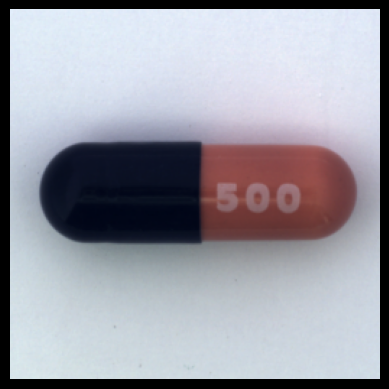

In [11]:
# Carica l'immagine
good_image_index = 2
# Metodo ottimizzato: usa np.interp per normalizzare rapidamente tra 0 e 255
good_img_example = df[good_image_index]
good_img_example = good_img_example.permute(1,2,0) # Converti (CHW -> HWC)
 
# Normalizzazione equivalente in PyTorch (tra 0 e 255, dtype uint8)
good_img_example = ((good_img_example - good_img_example.min()) / (good_img_example.max() - good_img_example.min()) * 255).to(torch.uint8).cpu()
plt.imshow(good_img_example)
print(f"Dimensioni immagine: {np.asarray(good_img_example).shape}")
plt.axis('off')
plt.show()

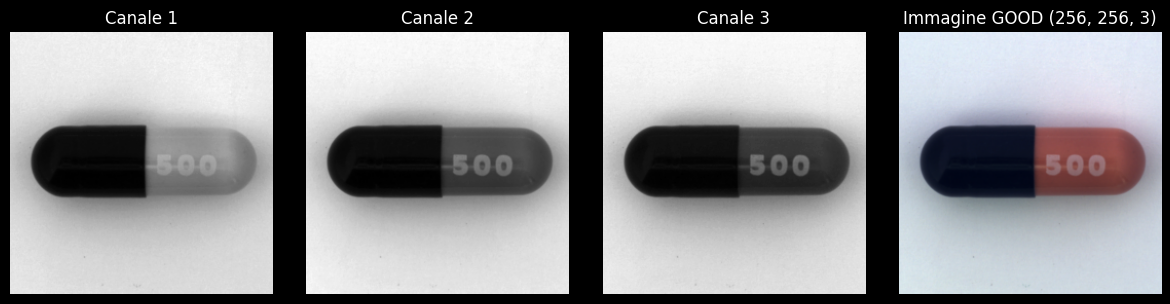

In [12]:
# Convert the PIL.Image object to a NumPy array
good_img_np = np.asarray(good_img_example)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(3):
    axs[i].imshow(good_img_np[..., i], cmap='gray')
    axs[i].set_title(f'Canale {i+1}')
    axs[i].axis('off')
axs[3].imshow(good_img_np)
axs[3].set_title('RGB')
axs[3].axis('off')
plt.tight_layout()
plt.title(f"Immagine GOOD {good_img_np.shape}")
plt.axis('off')
plt.show()

In [15]:
# 2 minutes

from typing import Literal


patch_size = 3
stride = 1
padding = 0
reduction = 'mean'

# Inizializza il modello di feature extraction
model = FeatureExtractor()
model.to(device)
model.eval()

# Function to process a list of images
def process_images_for_features(input : Literal[MVTecDataset , torch.Tensor], model, device, patch_size, stride, padding, reduction):
    """
    Processes a list of PIL Images or NumPy arrays, extracts features, and extracts compact patches.

    Args:
        image_list (list): A list of PIL Images or NumPy arrays.
        model (torch.nn.Module): The feature extraction model.
        device (torch.device): The device to use for computation (cuda, mps, or cpu).
        patch_size (int): The size of the square patch.
        stride (int): The stride for extracting patches.
        padding (int): The padding for extracting patches.
        reduction (str): The reduction method for patches ('mean', 'max', etc.).

    Returns:
        torch.Tensor: A tensor containing all extracted patches from all images.
    """

    if isinstance(input, MVTecDataset):
        input = [input[i] for i in range(len(input))]  # Converti il dataset in una lista di immagini
    elif not isinstance(input, list):
        input = [input]  # Assicurati che sia una lista cosicchè possa gestire un singolo elemento anche un ciclo for

    all_patches_list = []
    for img in input:
        # Ottimizzato: usa direttamente torch conversion e ridimensionamento
        if isinstance(img, Image.Image):
            img = img.resize((256, 256))
            img_tensor = transform(img).unsqueeze(0).to(device)
        elif isinstance(img, np.ndarray):
            img = Image.fromarray(img.astype(np.uint8)).resize((256, 256))
            img_tensor = transform(img).unsqueeze(0).to(device)
        elif isinstance(img, torch.Tensor):
            if img.dim() == 3:
                img = img.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
                img = Image.fromarray(img).resize((256, 256))
                img_tensor = transform(img).unsqueeze(0).to(device)
            else:
                raise ValueError("Torch tensor must be an image of shape (C, H, W)")
        else:
            raise TypeError("Input must be a PIL Image, NumPy array, or torch.Tensor")

        with torch.no_grad():
            features = model(img_tensor)
            patches = extract_compact_patches(features, patch_size=patch_size, stride=stride, padding=padding, reduction=reduction)
            all_patches_list.append(patches.cpu())

    # Concatenate patches from all images
    all_patches = torch.cat(all_patches_list, dim=0)
    return all_patches 

all_extracted_patches = process_images_for_features(df, model, device, patch_size, stride, padding, reduction)

input_length = len(df) if isinstance(df, MVTecDataset) else 1
patch_height = np.sqrt(all_extracted_patches.shape[0] // input_length).astype(int) # Adjust patch height calculation
patch_width = patch_height

print(f"Total patches extracted from {input_length} images: {len(all_extracted_patches)}")
print(f"Each patch is a vector of length: {all_extracted_patches.shape[1]} (number of channels)")
print(f"Each feature image from a single image has a shape of: {patch_height} * {patch_width} (height x width)")

Total patches extracted from 219 images: 14129004
Each patch is a vector of length: 100 (number of channels)
Each feature image from a single image has a shape of: 254 * 254 (height x width)


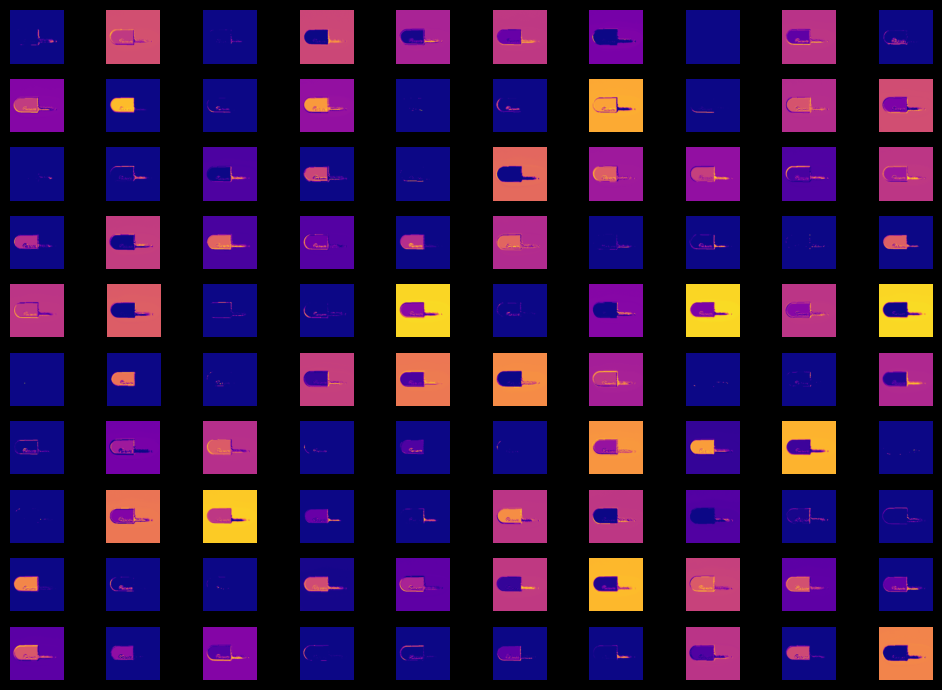

In [16]:
def generate_images_from_patches_boosted(all_patches, patch_height, patch_width):
    """
    Genera immagini dai patch e le ridimensiona utilizzando PyTorch per ottimizzare le operazioni.

    Args:
        all_patches (torch.Tensor): Tensor contenente tutti i patch di dimensione (num_patches, channels).
        patch_height (int): Altezza di ciascun patch.
        patch_width (int): Larghezza di ciascun patch.

    Returns:
        torch.Tensor: Tensor contenente le immagini ridimensionate di dimensione (num_images, patch_height, patch_width).
    """
    # Reshape diretto usando PyTorch per evitare loop
    img_index = all_patches.shape[0] // (patch_height * patch_width)
    all_patches = all_patches.reshape(img_index, patch_height, patch_width, -1)
    all_patches = all_patches.permute(0, 3, 1, 2)
    img_index, channels , patch_height , patch_width= all_patches.shape
    reshaped_images = all_patches.reshape(img_index,channels, patch_height, patch_width)
    return reshaped_images

# Generate images
fig, axs = plt.subplots(10, 10, figsize=(10, 7))
axs = axs.flatten()
images = generate_images_from_patches_boosted(all_extracted_patches, patch_height, patch_width)

# Display the patches
for i, img in enumerate(images[20]):
    im = axs[i].imshow(img, cmap='plasma')
    axs[i].axis('off')
    
plt.tight_layout()
plt.show()

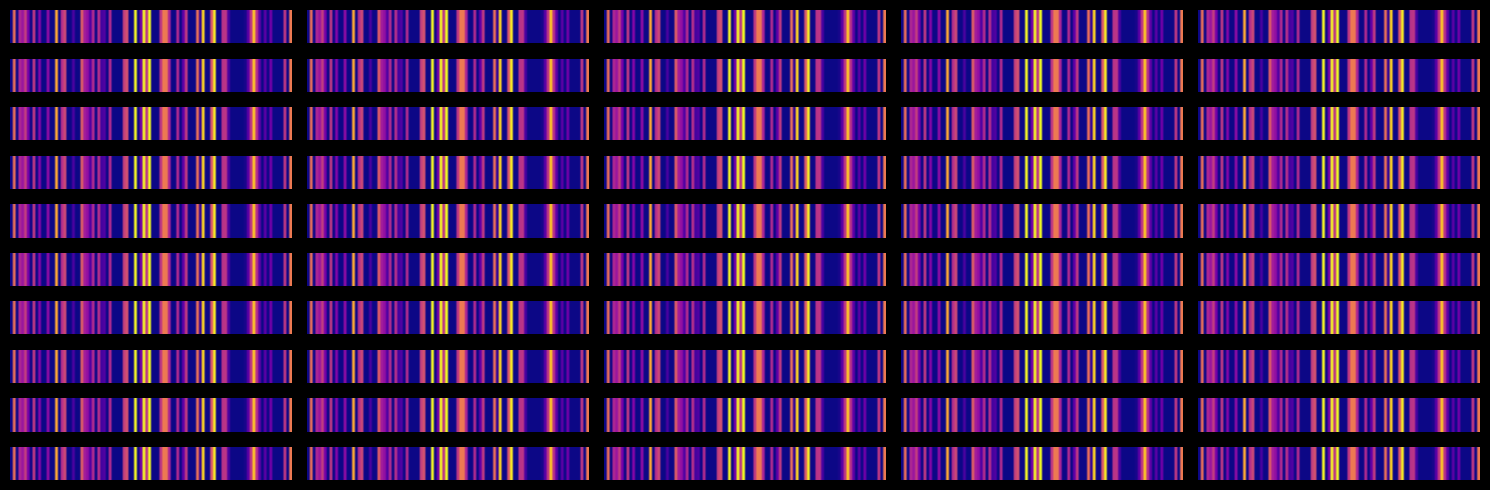

In [17]:
# Assumendo che all_patches sia un torch.Tensor, lo convertiamo in numpy
patches_np = all_extracted_patches.cpu().numpy()

# Numero di righe e colonne nella griglia
num_rows = 10
num_cols = 5

# Calcola il minimo e il massimo per ogni colonna (indice)
col_min = patches_np.min(axis=0)
col_max = patches_np.max(axis=0)

# Evita la divisione per zero
range_col = col_max - col_min
range_col[range_col == 0] = 1  # Se il range è 0, impostalo a 1 per evitare errori

# Normalizza ogni elemento relativamente alla colonna
normalized_patches = (patches_np - col_min) / range_col

# Crea la figura e gli assi
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5))


# Itera sulle patch selezionate e sugli assi
for i, patch in enumerate(normalized_patches[7115:7165]):
    row = i // num_cols
    col = i % num_cols
    
    # Reshape della patch in una matrice 1x100
    patch_reshaped = patch.reshape(1, -1)
    
    # Mostra la heatmap
    axs[row, col].imshow(patch_reshaped, cmap='plasma', aspect='auto')
    axs[row, col].axis('off')  # Nascondi gli assi

# Migliora il layout
plt.tight_layout()
plt.show()

In [18]:
# Convert the patches to numpy for FAISS K-means
# Ensure it's on CPU and is float32
patches_for_kmeans = all_extracted_patches.cpu().numpy().astype('float32')

# Define the number of clusters
k = 100
dimension = patches_for_kmeans.shape[1]

# Initialize and train the K-means model
kmeans = faiss.Kmeans(dimension, k, niter=20, verbose=True, gpu=False) # Use CPU for KMeans
kmeans.train(patches_for_kmeans)

# Get the centroids (optional)
# centroids = kmeans.centroids

# Assign each patch to a cluster
# D is distances, I is cluster assignments
D, I = kmeans.index.search(patches_for_kmeans, 1)

# I contains the cluster index for each patch
cluster_assignments = I[:, 0]

# Create the sub_bank by selecting 1% from each cluster
sub_bank_list = []
percentage_to_select = 0.01

for cluster_id in range(k):
    # Get the indices of patches belonging to the current cluster
    indices_in_cluster = np.where(cluster_assignments == cluster_id)[0]

    if len(indices_in_cluster) > 0:
        # Calculate the number of patches to select from this cluster (minimum 1)
        num_to_select = max(1, int(len(indices_in_cluster) * percentage_to_select))

        # Randomly select indices from the current cluster
        selected_indices = np.random.choice(indices_in_cluster, size=num_to_select, replace=False)

        # Get the corresponding patches and add them to the sub_bank list
        sub_bank_list.append(torch.from_numpy(patches_for_kmeans[selected_indices]))

# Concatenate the selected patches from all clusters
sub_bank = torch.cat(sub_bank_list, dim=0)

print(f"Original number of patches: {len(all_extracted_patches)}")
print(f"Number of patches in sub_bank: {len(sub_bank)}")
print(f"Shape of sub_bank: {sub_bank.shape}")

Sampling a subset of 25600 / 14129004 for training
Clustering 25600 points in 100D to 100 clusters, redo 1 times, 20 iterations
  Preprocessing in 29.02 s
  Iteration 19 (0.19 s, search 0.17 s): objective=25.1128 imbalance=16.276 nsplit=0       
Original number of patches: 14129004
Number of patches in sub_bank: 141243
Shape of sub_bank: torch.Size([141243, 100])


In [19]:
# Importa faiss-gpu e carica tutti i vettori contenuti in all_good_patches

# Assicurati che all_good_patches sia un torch.Tensor su CPU
if isinstance(sub_bank, torch.Tensor):
    vectors = sub_bank.cpu().numpy().astype('float32')
else:
    vectors = np.array(sub_bank, dtype='float32')

print(f"Shape dei vettori caricati in FAISS: {vectors.shape}")

Shape dei vettori caricati in FAISS: (141243, 100)


In [20]:
# Crea un indice L2 flat solo CPU
index_L2 = faiss.IndexFlatL2(vectors.shape[1])
index_ip = faiss.IndexFlatIP(vectors.shape[1])  

# Aggiungi i vettori all'indice CPU
index_L2.add(vectors)
index_ip.add(vectors)

print(f"Indice FAISS_IP creato su CPU. Numero di vettori indicizzati: {index_ip.ntotal}")
print(f"Indice FAISS_L2 creato su CPU. Numero di vettori indicizzati: {index_L2.ntotal}")

Indice FAISS_IP creato su CPU. Numero di vettori indicizzati: 141243
Indice FAISS_L2 creato su CPU. Numero di vettori indicizzati: 141243


Dimensioni immagine: (256, 256, 3)
Defect type: scratch, File name: 021.png


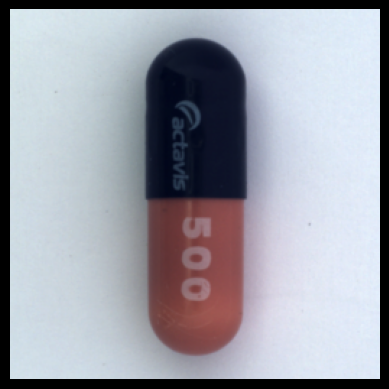

In [77]:
df_test = MVTecDataset(category='capsule', train=False, transform=transform)
index_to_test = 42
test_img_tensor, defect_type, file_name = df_test[index_to_test]
test_img_tensor = rotate_image_90(test_img_tensor)
test_img = test_img_tensor.permute(1,2,0) # Converti (CHW -> HWC)

# Normalizzazione equivalente in PyTorch (tra 0 e 255, dtype uint8)
test_img = ((test_img - test_img.min()) / (test_img.max() - test_img.min()) * 255).to(torch.uint8).cpu()
plt.imshow(test_img)
print(f"Dimensioni immagine: {np.asarray(test_img).shape}")
print(f"Defect type: {defect_type}, File name: {file_name}")
plt.axis('off')
plt.show()

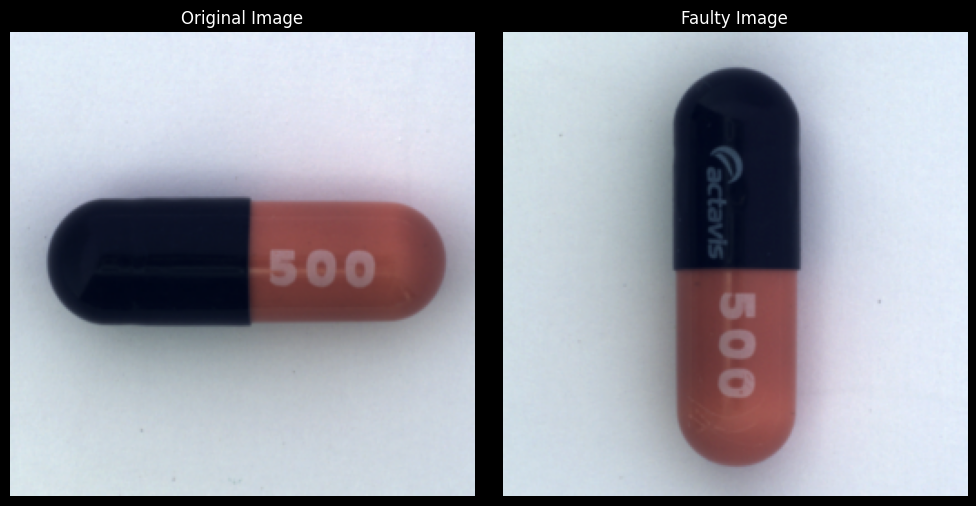

In [78]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Mostra good_img
axs[0].imshow(good_img_example)
axs[0].set_title("Original Image")
axs[0].axis('off')

# Mostra test_img
axs[1].imshow(test_img)
axs[1].set_title("Faulty Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [79]:
tensor, anomaly_type, file_name = df_test[index_to_test]
tensor = rotate_image_90(tensor)

In [80]:
test_patches = process_images_for_features(
    input=tensor, 
    model=model, 
    device=device, 
    patch_size=patch_size, 
    stride=1, 
    padding=padding, 
    reduction='mean'
    )

input_length = len(df) if isinstance(tensor, MVTecDataset) else 1
patch_height = np.sqrt(test_patches.shape[0] // input_length).astype(int) # Adjust patch height calculation
patch_width = patch_height

print(f"Total patches extracted from {input_length} images: {len(test_patches)}")
print(f"Each patch is a vector of length: {test_patches.shape[1]} (number of channels)")
print(f"Each feature image from a single image has a shape of: {patch_height} * {patch_width} (height x width)")

Total patches extracted from 1 images: 64516
Each patch is a vector of length: 100 (number of channels)
Each feature image from a single image has a shape of: 254 * 254 (height x width)


In [81]:
k = 10  # Numero di vicini più prossimi da cercare
# Converte test_patches in numpy array se necessario
if isinstance(test_patches, torch.Tensor):
    test_vectors = test_patches.cpu().numpy().astype('float32')
else:
    test_vectors = np.array(test_patches, dtype='float32')

# Per ogni patch, cerca i 3 vicini più prossimi (k=3)
D_l2, I_l2 = index_L2.search(test_vectors, 3)  # D: distanze, I: indici
D_ip, I_ip = index_ip.search(test_vectors, 3)  # D: distanze, I: indici

D_dict = {
    'l2': D_l2,
    'ip': D_ip
}

In [82]:
D_dict['l2'].max() , D_dict['ip'].max()

(0.07184577, 0.70555776)

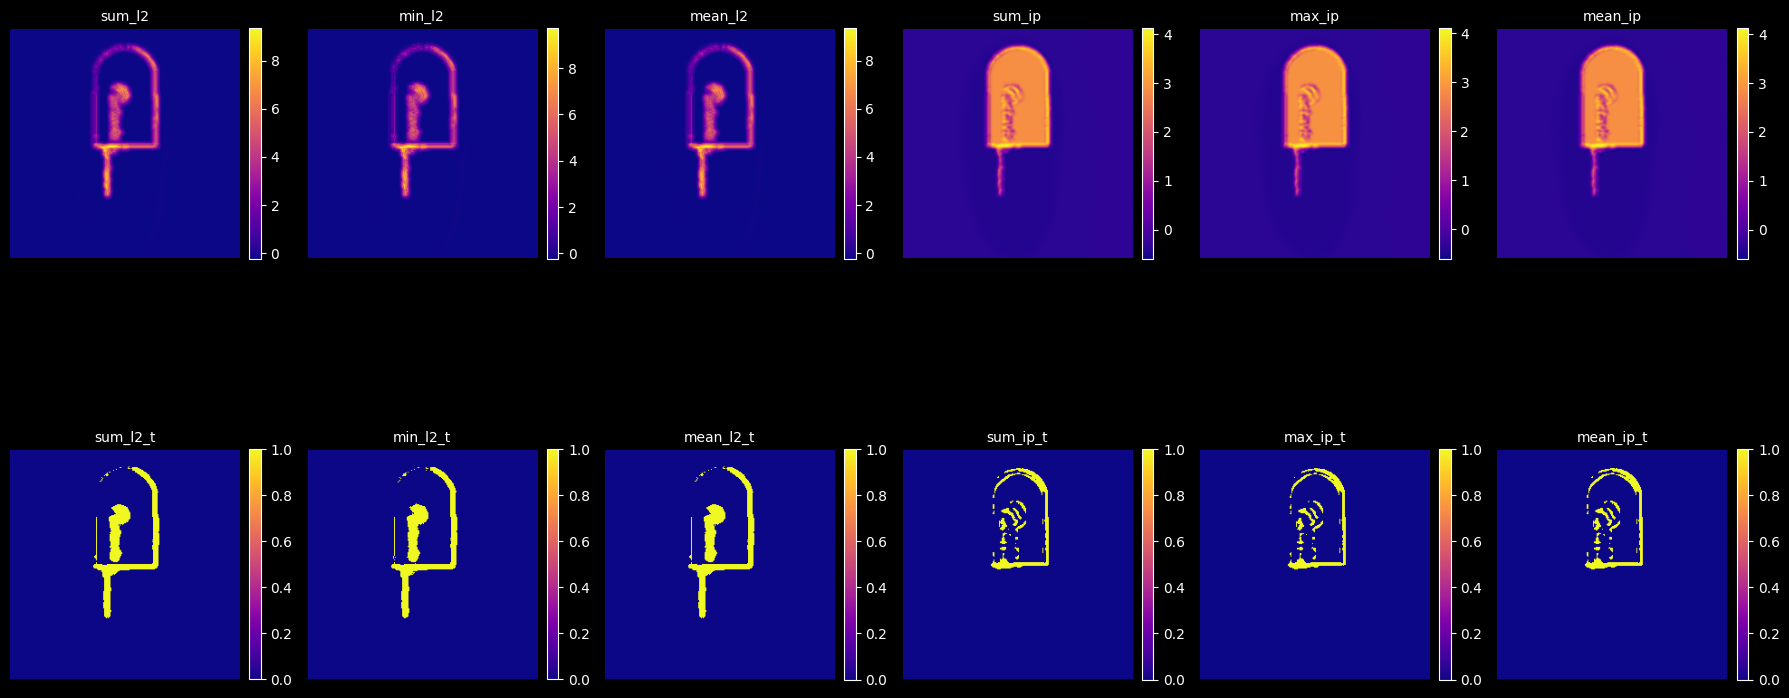

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def compute_and_plot_heatmaps(D : dict, 
                              l2_squared=True,
                              percentile_thresh=95, 
                              smooth_sigma=None):
    """
    D: array shape (n_queries, k) output da faiss index.search
    metric: 'l2' or 'ip' (inner product)
    l2_squared: se True, D è squared L2 (IndexFlatL2); verrà fatto sqrt
    patch_height, patch_width: griglia delle patch (n_h * n_w == n_queries)
    percentile_thresh: soglia percentilica per binarizzare
    smooth_sigma: se not None, applica gaussian smoothing per visualizzazione
    """

    D_l2 = D['l2'] if 'l2' in D else None
    D_ip = D['ip'] if 'ip' in D else None

    patch_height = np.sqrt(D_l2.shape[0]).astype(int) # Adjust patch height calculation
    patch_width = patch_height
    eps = 1e-8

    # D viene da faiss: se è squared L2, prendi radice
    if l2_squared:
        D_proc = np.sqrt(np.maximum(D_l2, 0.0))
    else:
        D_proc = D_l2.copy()

    # score candidates: somma, media, minimo (più grande = più anomalo)
    score_sum = np.sum(D_proc, axis=1)
    score_mean = np.mean(D_proc, axis=1)
    score_min = np.min(D_proc, axis=1)  # prendo il singolo migliore dei k
    scores_dict = {}
    scores_dict['sum_l2'] = score_sum
    scores_dict['min_l2'] = score_min
    scores_dict['mean_l2'] = score_mean
    # D contiene similarity scores (più grande = più simile)
    # Convertiamo similarity -> anomaly score: più alto = più anomalo
    # Opzione semplice: anomaly = -similarity (prima calcoliamo mean/max/sum)
    sim_sum = np.sum(D_ip, axis=1)
    sim_mean = np.mean(D_ip, axis=1)
    sim_max = np.max(D_ip, axis=1) # prendo il più simile dei k

    # Inverti per ottenere "distanza-like" (più grande = più anomalo)
    # Ma è meglio normalizzare prima di invertire per renderlo comparabile tra immagini
    # Qui useremo inversione semplice: -sim_*  (poi z-score)
    scores_dict['sum_ip'] = -sim_sum
    scores_dict['max_ip'] = -sim_max
    scores_dict['mean_ip'] = -sim_mean

    # --- Normalizzazione z-score per ogni score ---
    zscores = {}
    for name, arr in scores_dict.items():
        arr = np.asarray(arr, dtype=np.float32)
        z = (arr - arr.mean()) / (arr.std() + eps)
        zscores[name] = z

    # --- Thresholding (percentile sullo z-score come fai) ---
    threshs = {name: np.percentile(z, percentile_thresh) for name, z in zscores.items()}
    heatmaps = {}
    heatmaps_thresh = {}
    for name, z in zscores.items():
        hm = z.reshape(patch_height, patch_width)
        if smooth_sigma is not None:
            hm = gaussian_filter(hm, sigma=smooth_sigma)
        heatmaps[name] = hm
        heatmaps_thresh[name + '_t'] = (hm > threshs[name]).astype(np.float32)

    # --- plotting: manteniamo ordine simile al tuo originale (6 + 6) ---
    keys = list(heatmaps.keys())
    thresh_keys = list(heatmaps_thresh.keys())
    all_keys = keys + thresh_keys
    n_plots = len(all_keys)
    # Layout 2 x ceil(n/2)
    ncols = 6
    nrows = 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(18, 10))
    axs = axs.flatten()
    for i, key in enumerate(all_keys):
        ax = axs[i]
        im = ax.imshow(heatmaps[key] if key in heatmaps else heatmaps_thresh[key], cmap='plasma')
        ax.set_title(key, fontsize=10)
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Nascondi eventuali assi extra
    for j in range(n_plots, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

    return heatmaps, heatmaps_thresh, zscores, threshs

heatmaps, heatmaps_thresh, zscores, threshs = compute_and_plot_heatmaps(
    D=D_dict, 
    l2_squared=True,
    percentile_thresh=96,
    smooth_sigma=None)


In [76]:
heatmaps['max_ip'].max() , heatmaps['mean_ip'].max() , heatmaps['sum_l2'].max()

(4.0139766, 4.078635, 10.234717)

In [52]:
heatmaps['min_l2'].max() , heatmaps['mean_l2'].max() , heatmaps['sum_l2'].max()

(13.039773, 12.409235, 12.409238)

In [ ]:
good_img = df[good_image_index]
test_img = rotate_image_90(df_test[index_to_test][0])

min_distances = heatmaps['']

# Ricostruisci la mappa 2D delle distanze minime (assumendo patch_height e patch_width già definiti)
min_distances_2d = min_distances.reshape(patch_height, patch_width)

# Ridimensiona le immagini ai lati alla stessa dimensione della heatmap
target_size = (min_distances_2d.shape[1], min_distances_2d.shape[0])

# If test_img is a NumPy array, convert it to a PIL Image first
if isinstance(test_img, np.ndarray):
    test_img = Image.fromarray(test_img)
if isinstance(good_img, np.ndarray):
    good_img = Image.fromarray(good_img)

import torchvision.transforms.functional as F
resized_good_img = F.resize(good_img, target_size)
resized_test_img = F.resize(test_img, target_size)

resized_good_img = ((resized_good_img - resized_good_img.min()) / (resized_good_img.max() - resized_good_img.min()) * 255).to(torch.uint8).cpu()
resized_test_img = ((resized_test_img - resized_test_img.min()) / (resized_test_img.max() - resized_test_img.min()) * 255).to(torch.uint8).cpu()

resized_good_img = resized_good_img.permute(1,2,0) # Converti (CHW -> HWC)
resized_test_img = resized_test_img.permute(1,2,0) # Converti (CHW -> HWC)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Immagine originale
axs[0].imshow(resized_good_img)
axs[0].set_title("Immagine Originale")
axs[0].axis('off')

# Heatmap (stessa size delle immagini)
im = axs[1].imshow(min_distances_2d, cmap='magma', aspect='auto')
axs[1].set_title('Heatmap delle distanze minime (anomaly map)')
axs[1].axis('off')
# fig.colorbar(im, ax=axs[1], shrink=0.8, label='Distanza dal vicino più vicino')

# Immagine anomala
axs[2].imshow(resized_test_img)
axs[2].set_title("Immagine Anomala")
axs[2].axis('off')

plt.tight_layout()
plt.show()